In [1]:
import flodym as fd

In [2]:
dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [29]:
parameter_definitions = [
    fd.ParameterDefinition(name="dewatering", dim_letters=("s",)),
    fd.ParameterDefinition(name="manure", dim_letters=("s",)),
]

In [30]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [31]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("s",)),
]

In [32]:
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),  # Only substance dimension
        time_letter="s",
        subclass=fd.InflowDrivenDSM,
        lifetime_model_class=fd.LogNormalLifetime,
    ),
]


In [33]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    #stocks=[],
    stocks=stock_definitions,
)

In [34]:
dimension_files = {
    "substance": "data/dimension_dewatering.csv",
}

In [35]:
parameter_files = {
    "dewatering": "data/parameter_dewatering.csv",
    "manure": "data/parameter_manure.csv",
}


In [39]:
class SimpleMFA(fd.MFASystem):
    def compute(self):

        # dewatering flows
        self.flows["sysenv => dewatering"][...] = self.parameters["manure"]
        self.flows["dewatering => soil application"][...] = self.flows["sysenv => dewatering"] * self.parameters["dewatering"]
        self.flows["dewatering => storage"][...] = self.flows["sysenv => dewatering"] - self.flows["dewatering => soil application"]

        # end-of-life  flow
        self.flows["soil application => sysenv"][...] = self.flows["dewatering => soil application"]
        self.flows["storage => sysenv"][...] = self.flows["dewatering => storage"]



In [40]:
mfa_example = SimpleMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [42]:
mfa_example.compute()

In [43]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of SimpleMFA object...
INFO:root:Success - Mass balance is consistent!


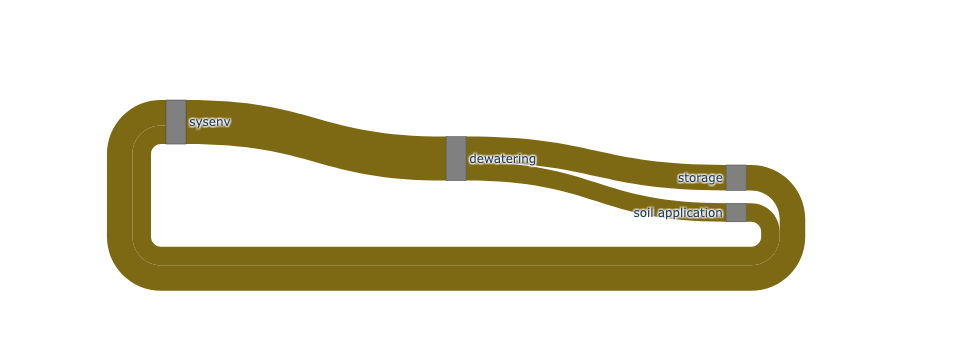

In [57]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_example, exclude_processes=[], flow_color_dict = {"default":"rgb(125,105,19)"}).plot() 
fig.show()